# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [94]:
# загрузим необходимые библиотеки:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OrdinalEncoder 

from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, roc_curve, confusion_matrix, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

**План работы:**  
1. Подготовка данных:  
    1.1 Преобразуем данные к нужному типу.  
    1.2 Избавимся от не значимых критериев (например, PaperlessBilling)  
    1.3 Сгенерируем дополнительных признаков (например, Life Time)  
    1.4 Закодируем категориальные признаки методом OHE  
    1.5 Оценим мультиколинеарность признаков.  
    1.6 Избавимся от дисбаланса классов.  
2.Исследование задачи  
    2.1 Попробуем различные модели для обучения  
3. Тестирование  
    3.1 Протеструем выбранную модель на тестовой выборке.  

## 1. Подготовка данных

In [3]:
# загрузим данные
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

**EDA contract DF**

In [4]:
contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4566,8375-KVTHK,2014-06-01,No,One year,Yes,Electronic check,100.30,6754.35
4162,0769-MURVM,2014-02-01,No,Two year,No,Bank transfer (automatic),65.70,4575.35
1054,5981-ITEMU,2016-08-01,2019-12-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),97.10,3706.95
4436,3639-XJHKQ,2018-07-01,No,Month-to-month,Yes,Electronic check,60.60,1297.8
5477,2725-TTRIQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),84.20,5986.55
5485,7794-JASDG,2020-01-01,No,Month-to-month,Yes,Mailed check,50.75,50.75
386,0533-BNWKF,2015-05-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.45,4874.7
3136,3884-HCSWG,2018-06-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.00,1144.5
4417,0515-YPMCW,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,70.45,70.45
465,2996-XAUVF,2014-04-01,No,Two year,Yes,Mailed check,40.05,2799.75


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Для дальнейшей работы нужно преобразовать типы BeginDate и EndDate в datetime, TotalCharges во float.

In [6]:
# в поле TotalCharges имеются пустые значения, для новых клиентов, подключенных только первый месяц

contract.loc[contract['TotalCharges'] == ' ','TotalCharges'] = contract[contract['TotalCharges'] == ' ']['MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype('float') 
# пустые значения в TC стояли для новых клиентов

In [7]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64[ns]') 

In [8]:
target = contract['EndDate']
target = np.where(target=='No', 0, 1)

In [9]:
contract['customerID'].duplicated().sum()

0

Все ID клиентов уникальны

<AxesSubplot:xlabel='BeginDate'>

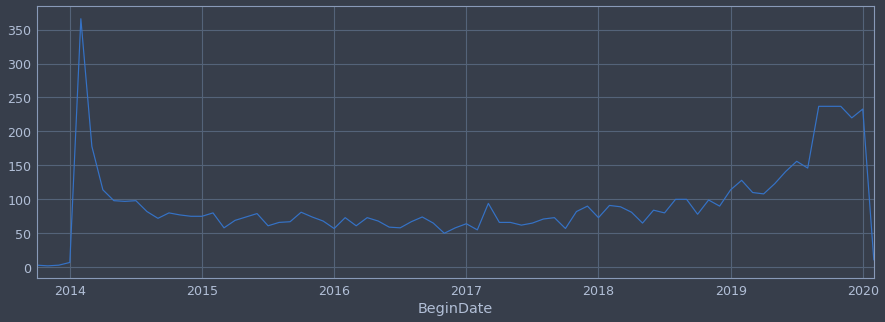

In [10]:
contract.groupby('BeginDate').size().plot.line(figsize=(15,5))

In [11]:
contract[contract['BeginDate'] >= '2020-01-01'].groupby('BeginDate').size()

BeginDate
2020-01-01    233
2020-02-01     11
dtype: int64

In [12]:
contract[contract['BeginDate'] == '2019-01-01']['BeginDate'].value_counts()

2019-01-01    114
Name: BeginDate, dtype: int64

Видим активный рост после запуска в 2014 году, так же плавный рост с середины 2019 года. Резкий спад в конце графика связан вероятнее всего с отсутствием данных за февраль.

In [13]:
contract[contract['EndDate'] == 'No'].EndDate.count()

5174

Значение кроме No в EndDate есть у 26.5% клиентов. То есть наш датасет не сбалансирован, это нужно будет учесть при обучении.

In [14]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'
contract['EndDate'] = contract['EndDate'].astype('datetime64[ns]')
contract['LifeTime'] = (contract['EndDate'] - contract['BeginDate']).dt.days

# преобразуем enddate в булиев массив
contract['EndDate'] = target

In [15]:
# избавимся от полей BeginDate и PaperlessBilling, чтобы не путать модель лишними признаками
contract.drop(columns=['BeginDate', 'PaperlessBilling'], inplace=True)
contract.head()

,customerID,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime
0,7590-VHVEG,0,Month-to-month,Electronic check,29.85,29.85,31
1,5575-GNVDE,0,One year,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,1,Month-to-month,Mailed check,53.85,108.15,61
3,7795-CFOCW,0,One year,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,1,Month-to-month,Electronic check,70.70,151.65,61


<AxesSubplot:>

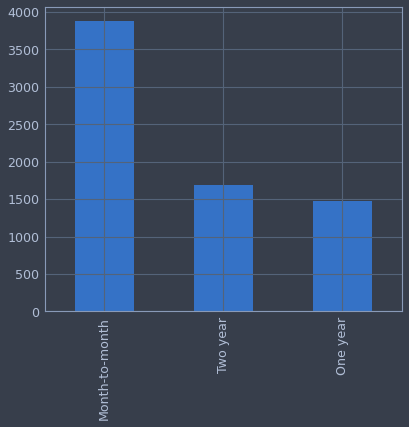

In [16]:
contract['Type'].value_counts().plot.bar()

БОльшая часть клиентов использует помесячную оплату

<AxesSubplot:>

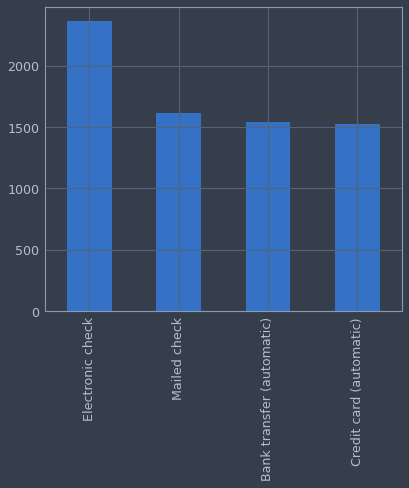

In [17]:
contract['PaymentMethod'].value_counts().plot.bar()

/home/dmitriy/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MonthlyCharges', ylabel='Density'>

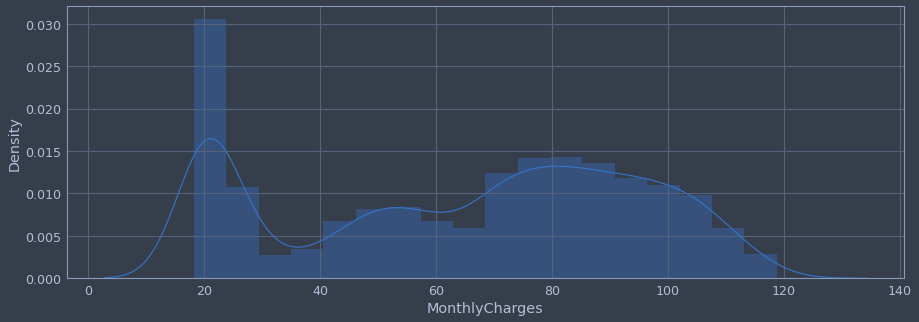

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(contract['MonthlyCharges'])

Распределение не нормально. Есть пик в районе 20$, вероятно имеем много пользователей, у которых подключена только одна услуга (например интернет)

In [19]:
print('Клиентов с месячным чеком менее 30 долл.:')
display(contract[contract['MonthlyCharges'] < 30].shape[0])

print('Из низ клиентов с интернетом:')
display(contract[contract['MonthlyCharges'] < 30].merge(internet, how='left').InternetService.notna().sum())

print('Из низ клиентов с телефонией:')
display(contract[contract['MonthlyCharges'] < 30].merge(phone, how='left').MultipleLines.notna().sum())

Клиентов с месячным чеком менее 30 долл.:


1653

Из низ клиентов с интернетом:


127

Из низ клиентов с телефонией:


1526

/home/dmitriy/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


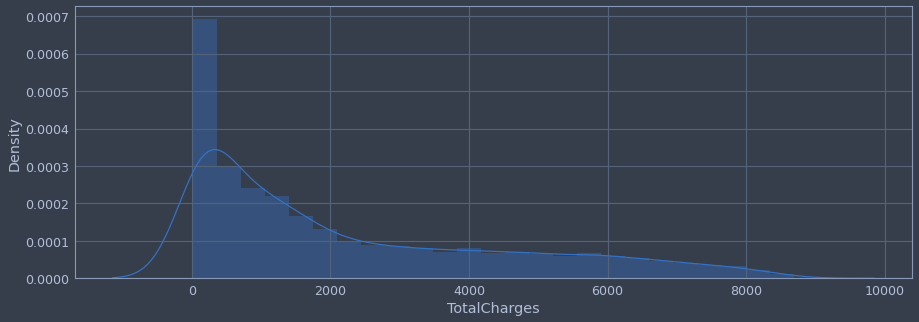

In [20]:
plt.figure(figsize=(15,5))
ax = sns.distplot(contract['TotalCharges'])

такой график выглядит естественно. Клиентов с большим LTV предсказуемо меньше, чем выше LTV.

**EDA internet DF**

In [21]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4112,9591-YVTEB,DSL,Yes,Yes,No,No,Yes,No
2397,7855-DIWPO,Fiber optic,No,No,No,No,No,No
3132,0420-HLGXF,Fiber optic,No,No,Yes,No,Yes,Yes
3109,3441-CGZJH,DSL,Yes,No,Yes,Yes,Yes,Yes
244,8266-VBFQL,Fiber optic,No,No,Yes,Yes,No,Yes
4117,5424-RLQLC,DSL,No,Yes,No,No,Yes,No
2090,3166-PNEOF,DSL,Yes,No,Yes,Yes,Yes,Yes
5022,8221-EQDGL,DSL,Yes,Yes,Yes,No,No,No
2130,0431-APWVY,Fiber optic,No,No,No,No,Yes,Yes
751,6630-UJZMY,Fiber optic,No,No,No,No,Yes,No


In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


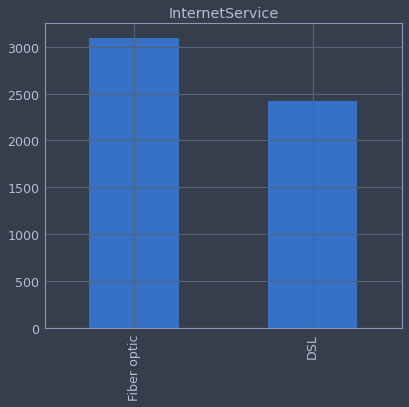

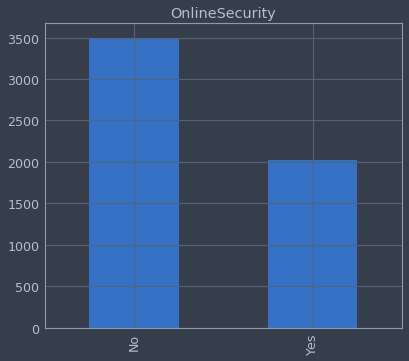

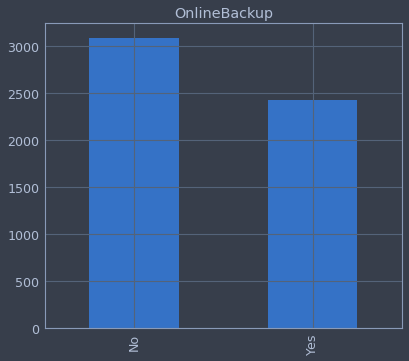

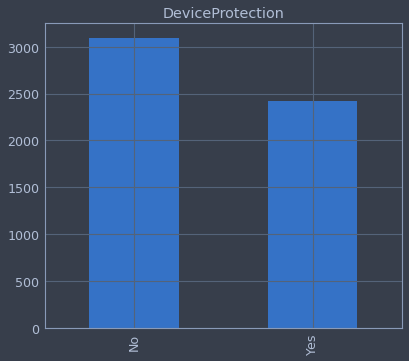

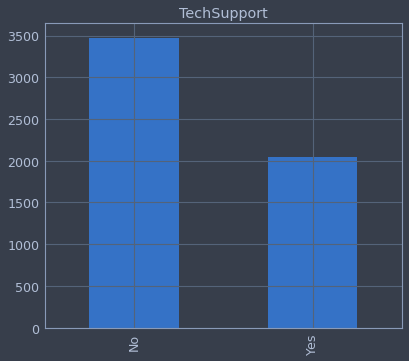

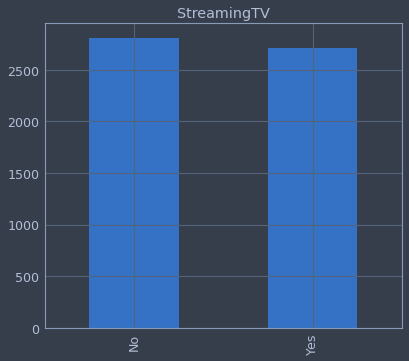

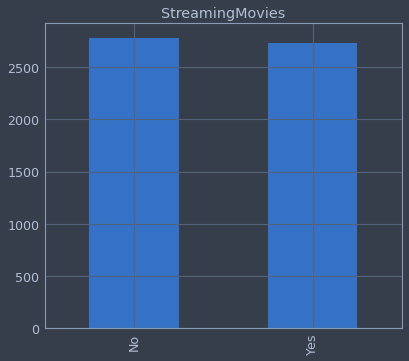

In [23]:
lst = internet.drop(columns=['customerID']).columns
for i in lst:
    ax = internet[i].value_counts().plot.bar()
    plt.title(i)
    plt.show()

**EDA personal DF**

In [24]:
personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
1479,6281-FKEWS,Female,0,No,No
1640,2351-RRBUE,Female,0,Yes,Yes
548,4676-MQUEA,Male,1,Yes,No
89,3016-KSVCP,Male,0,Yes,No
6197,1585-MQSSU,Male,0,No,No
3513,4063-EIKNQ,Male,0,Yes,Yes
758,2189-WWOEW,Female,0,No,Yes
3087,6979-ZNSFF,Female,0,No,No
2751,7909-FIOIY,Female,0,Yes,Yes
3548,0670-ANMUU,Male,0,No,No


In [25]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<AxesSubplot:>

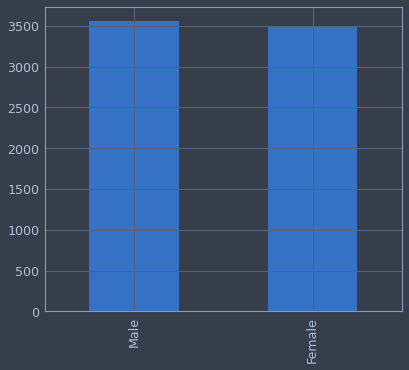

In [26]:
personal['gender'].value_counts().plot.bar()

Мужчин и женщин почти поровну

In [27]:
personal['SeniorCitizen'].sum()/personal.shape[0]

0.1621468124378816

16% пожилых граждан

<AxesSubplot:>

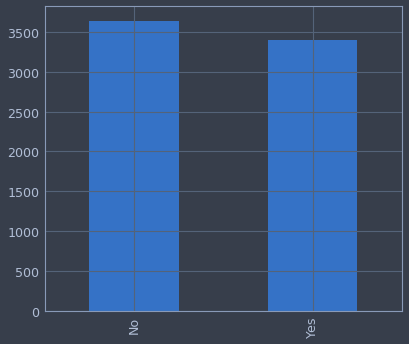

In [28]:
personal['Partner'].value_counts().plot.bar()

<AxesSubplot:>

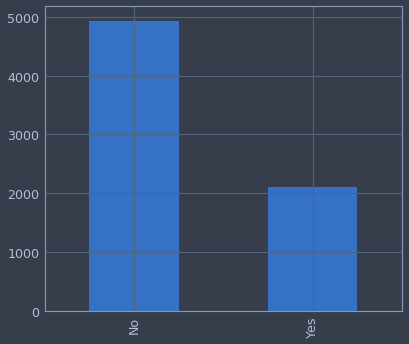

In [29]:
personal['Dependents'].value_counts().plot.bar()

**EDA PHONE DF**

In [30]:
phone.sample(10)

,customerID,MultipleLines
2447,2608-BHKFN,No
351,0177-PXBAT,Yes
828,6513-EECDB,Yes
1702,7940-UQQUG,Yes
1930,7607-QKKTJ,Yes
6104,1241-FPMOF,No
5172,6476-YHMGA,No
5156,0193-ESZXP,No
1118,0178-SZBHO,Yes
5608,7542-CYDDM,No


In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<AxesSubplot:>

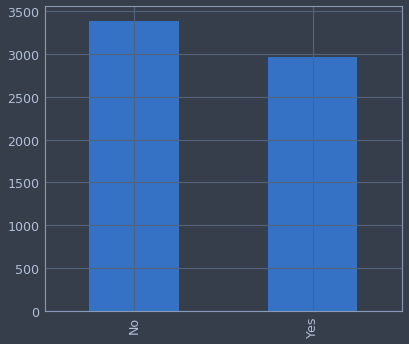

In [32]:
phone['MultipleLines'].value_counts().plot.bar()

Признак распределен почти одинаково.

In [33]:
internet['customerID'].isin(phone['customerID'].unique()).sum()

4835

имеем пересечение 68% датасета у кого имеются услуги и интернета и телефонии

Объединим датасеты для дальнейшей работы

In [34]:
# заполним пропуски строкой No, это позволит нам сохранить обекты и не "раздует" кодирование признаков
full_telecom_data = contract.merge(personal)
full_telecom_data = full_telecom_data.merge(phone, how='left').fillna('No')
full_telecom_data = full_telecom_data.merge(internet, how='left').fillna('No')

In [35]:
# закодируем категориальные признаки методом OHE

ohe_data = pd.get_dummies(full_telecom_data.drop(columns=['EndDate','customerID']), drop_first=True)
ohe_data[['EndDate']]=full_telecom_data[['EndDate']]

ohe_data.head()

,MonthlyCharges,TotalCharges,LifeTime,SeniorCitizen,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,EndDate
0,29.85,29.85,31,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,1036,0,1,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,61,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,1
3,42.30,1840.75,1371,0,1,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,61,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [36]:
def prob(group_by):
    df = pd.crosstab(index = full_telecom_data[group_by], columns = full_telecom_data.EndDate).reset_index()
    df['prob'] = df[1] / (df[1] + df[0])
    return df[[group_by, 'prob']]

In [37]:
prob_col= ['gender',  'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies']
for col in prob_col:
    display(prob(col))

EndDate,gender,prob
0,Female,0.269209
1,Male,0.261603


EndDate,Partner,prob
0,No,0.329580
1,Yes,0.196649


EndDate,Dependents,prob
0,No,0.312791
1,Yes,0.154502


EndDate,MultipleLines,prob
0,No,0.250246
1,Yes,0.286099


EndDate,InternetService,prob
0,DSL,0.189591
1,Fiber optic,0.418928
2,No,0.074050


EndDate,OnlineSecurity,prob
0,No,0.313296
1,Yes,0.146112


EndDate,OnlineBackup,prob
0,No,0.291721
1,Yes,0.215315


EndDate,DeviceProtection,prob
0,No,0.286518
1,Yes,0.225021


EndDate,TechSupport,prob
0,No,0.311862
1,Yes,0.151663


EndDate,StreamingTV,prob
0,No,0.243312
1,Yes,0.300702


EndDate,StreamingMovies,prob
0,No,0.243795
1,Yes,0.299414


<AxesSubplot:>

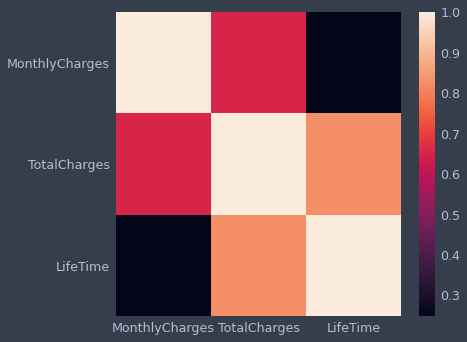

In [38]:
correl = full_telecom_data.drop(columns=['EndDate','SeniorCitizen']).corr()

# построим тепловую карту
sns.heatmap(correl, xticklabels=correl.columns,
            yticklabels=correl.columns)

In [39]:
correl

,MonthlyCharges,TotalCharges,LifeTime
MonthlyCharges,1.000000,0.651182,0.247754
TotalCharges,0.651182,1.000000,0.826095
LifeTime,0.247754,0.826095,1.000000


Похоже имеется мультиколинеарность между MonthlyCharges, TotalCharge, LifeTime что закономерно. Избавимся от TotalCharges, так как корреляция между остальными признаками низкая.

In [40]:
ohe_data.drop(columns=['TotalCharges'], inplace=True)

**Вывод:**  
В рамках раздела мы проделали следующую работу:  
1. Загрузили и оценили данные.  
2. Преобразовали поля к нужным типам.  
3. Избавились от лишних признаов, в том числе после оценки мультиколинеарности.  
4. Закодировали признаки методом OHE


## 2. исследование задачи

In [41]:
# выделим признаки и поделим их на обучающую и тестовую выборки
features = ohe_data.drop(columns=['EndDate'])
target = ohe_data['EndDate']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.20, random_state=2021)

In [42]:
# оценим дисбананс целевого признака
target.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: EndDate, dtype: float64

Для борьбы с дисбалансом я буду использовать параметр моделей class_weight, так как по предыдущим работам такой способ показал аналогичную с upscale эффективность. Из-за небольшого кол-ва признагов downscale в работе не целесообразен.

In [43]:
# подготовим оценщик дл кросс валидации
scorer_roc_auc = make_scorer(roc_auc_score, greater_is_better=True)
scorer_accuracy = make_scorer(accuracy_score, greater_is_better=True)

scoring = {'AUC': scorer_roc_auc, 'Accuracy': scorer_accuracy}

**ОБУЧЕНИЕ МОДЕЛЕЙ**

Начнём с линейной регрессии

In [46]:
%%time
best_result = 0
model = LogisticRegression(class_weight='balanced',
                           solver='liblinear', max_iter=400)
score = cross_validate(model, features_train, target_train,
                       scoring=scoring, cv=5, return_train_score=True)
print("Среднее значение метрики roc-auc:", score['test_AUC'].mean())
print("Среднее значение метрики accuracy:", score['test_Accuracy'].mean())

Среднее значение метрики roc-auc: 0.7651654107438979
Среднее значение метрики accuracy: 0.7497318365140481
CPU times: user 1.62 s, sys: 1.74 s, total: 3.36 s
Wall time: 383 ms


модель с ходу даёт значение метрики достаточное для сдачи проекта:)

Дерево решений:

In [47]:
sc = 0
for depth in range(6, 20, 2):
    model = DecisionTreeClassifier(
        max_depth=depth, random_state=2021, class_weight='balanced')
    score = cross_validate(model, features_train, target_train,
                           scoring=scoring, cv=5, return_train_score=True)
    if score['test_AUC'].mean() > sc:
        print(
            f"Среднее значение метрики roc-auc при max_depth={depth}:", score['test_AUC'].mean())
        print(
            f"Среднее значение метрики accuracy при max_depth={depth}:", score['test_Accuracy'].mean())
        print("_________________________________________________________")
        sc = score['test_AUC'].mean()

Среднее значение метрики roc-auc при max_depth=6: 0.7605536428754209
Среднее значение метрики accuracy при max_depth=6: 0.7490323892318531
_________________________________________________________


немного хуже результат у целевой метрики у модели DecisionTreeClassifier

Случайный лес:

In [48]:
sc = 0
for depth in range(6, 20, 2):
    for estimators in range(10, 100, 10):
        model = RandomForestClassifier(
            n_estimators=estimators, max_depth=depth, random_state=2021, class_weight='balanced')
        score = cross_validate(model, features_train, target_train,
                               scoring=scoring, cv=5, return_train_score=True)
        if score['test_AUC'].mean() > sc:
            print(
                f"Среднее значение метрики roc-auc при max_depth={depth} и n_estimators={estimators}:", score['test_AUC'].mean())
            print(
                f"Среднее значение метрики accuracy при max_depth={depth} и n_estimators={estimators}:", score['test_Accuracy'].mean())
            print("_________________________________________________________")
            sc = score['test_AUC'].mean()

Среднее значение метрики roc-auc при max_depth=6 и n_estimators=10: 0.7697176852298421
Среднее значение метрики accuracy при max_depth=6 и n_estimators=10: 0.7641110100693302
_________________________________________________________
Среднее значение метрики roc-auc при max_depth=6 и n_estimators=20: 0.7712655167158017
Среднее значение метрики accuracy при max_depth=6 и n_estimators=20: 0.7628664099820173
_________________________________________________________
Среднее значение метрики roc-auc при max_depth=6 и n_estimators=30: 0.7722304092420659
Среднее значение метрики accuracy при max_depth=6 и n_estimators=30: 0.7626905237343993
_________________________________________________________
Среднее значение метрики roc-auc при max_depth=6 и n_estimators=40: 0.7763717801019354
Среднее значение метрики accuracy при max_depth=6 и n_estimators=40: 0.7662402423321633
_________________________________________________________
Среднее значение метрики roc-auc при max_depth=8 и n_estimators=30: 

Пока самый лучший результат у случайного леса

LGBM:

In [49]:
%%time
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=16, colsample_bytree=0.2,
                           min_child_weight=0.3, reg_alpha=0.2, min_child_samples=10, min_split_gain=0.019,
                           learning_rate=0.06, n_estimators=1100, max_depth=15, class_weight='balanced', random_state=2021)
score = cross_validate(model, features_train,
                       target_train, scoring=scoring, cv=5)
print(f"Среднее значение метрики roc-auc:", score['test_AUC'].mean())
print(f"Среднее значение метрики accuracy:", score['test_Accuracy'].mean())

Среднее значение метрики roc-auc: 0.8551288974175103
Среднее значение метрики accuracy: 0.8679444161632528
CPU times: user 1min 15s, sys: 343 ms, total: 1min 15s
Wall time: 7.09 s


Для тюнинга модели я использова итеративный подход для каждого параметра, чтобы не захламлять тетрадку, я исключил процесс подбора параметров. Можно было бы использовать GridSearch, но без него проще остановить процесс обучения, если итерация какого-то параметра не даёт заметного положителього эффекта.  
В целом модель очень хорошо себя показала при тюнинге и по скорости работы. На дефолтных параметрах модель показала уже 0.81 по roc-auc на кросс валидации.

CatBoost:

In [50]:
%%time
model = CatBoostClassifier(verbose=False, eval_metric='AUC', auto_class_weights='Balanced', 
                           n_estimators=900, learning_rate=0.05, depth=6,l2_leaf_reg=3,
                          random_strength=1,bagging_temperature=1)                           
score = cross_validate(model, features_train, target_train, scoring=scoring, cv=5)
print(f"Среднее значение метрики roc-auc:", score['test_AUC'].mean())
print(f"Среднее значение метрики accuracy:", score['test_Accuracy'].mean())

Среднее значение метрики roc-auc: 0.8296753522574496
Среднее значение метрики accuracy: 0.8553430175838967
CPU times: user 1min 5s, sys: 16.8 s, total: 1min 22s
Wall time: 16.3 s


Для тюнинга модели так же использовал итеративный подход. По дефолту модель показала результат хуже, чем LGBM, плюс в процессе тюнинга не удалось добиться значительного прироста. Максимального показателя roc-auc удалось добиться указав только параметр n_estimators, тюнинг прочих параметров в замене от дефолтных давал только обратный результат. В целом модель значительно дольше обучается, что делает тюнинг очень трудоемким процессом.  
Возможно низкая оттада от нюнинга связана с OHE, в рекомендациях по тюнингу https://catboost.ai/docs/concepts/parameter-tuning.html предупреждают об этом, но с учётом ограниченной вариативности параметров с трудом верится, что это может существенно отразиться на модели. В любом случае стоит попробовать ordinal encoder.

In [51]:
# категориальные признаки закодируем методом Ordinal encoder

cat_columns = ['Type', 'PaymentMethod',  'gender',  'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies']

encoder = OrdinalEncoder()

ordinal_data = pd.DataFrame(encoder.fit_transform(full_telecom_data[cat_columns]), 
                                                      columns=cat_columns) 

ord_data = ordinal_data.join(full_telecom_data[['EndDate', 'MonthlyCharges', 'TotalCharges',
                                                'LifeTime', 'SeniorCitizen']])
ord_data.head()

,Type,PaymentMethod,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,EndDate,MonthlyCharges,TotalCharges,LifeTime,SeniorCitizen
0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,29.85,29.85,31,0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,56.95,1889.50,1036,0
2,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,53.85,108.15,61,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,42.30,1840.75,1371,0
4,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,70.70,151.65,61,0


In [52]:
# выделим признаки и поделим их на обучающую и тестовую выборки
features = ord_data.drop(columns=['EndDate'])
target = ord_data['EndDate']

features_train,features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.20, random_state=2021)

In [53]:
%%time
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=16, colsample_bytree=0.2,
                           min_child_weight=0.3, reg_alpha=0.2,min_child_samples=10,min_split_gain=0.019,
                           learning_rate=0.06, n_estimators=1100, max_depth=15,class_weight='balanced', random_state=2021)
score = cross_validate(model, features_train, target_train, scoring=scoring, cv=5)
print(f"Среднее значение метрики roc-auc:", score['test_AUC'].mean())
print(f"Среднее значение метрики accuracy:", score['test_Accuracy'].mean())

Среднее значение метрики roc-auc: 0.822704406168914
Среднее значение метрики accuracy: 0.8358169648274787
CPU times: user 1min 19s, sys: 376 ms, total: 1min 20s
Wall time: 7.53 s


Ordinal encoder ухудшил значение метрики для LGBM, возможно с учётом изменения кол-ва входных параметров требуется новый тюнинг модели.

In [54]:
%%time
model = CatBoostClassifier(verbose=False, eval_metric='AUC', auto_class_weights='Balanced', n_estimators=900, 
                           learning_rate=0.05, depth=6, l2_leaf_reg=3, random_strength=1,bagging_temperature=1)                           
score = cross_validate(model, features_train, target_train, scoring=scoring, cv=5)
print(f"Среднее значение метрики roc-auc:", score['test_AUC'].mean())
print(f"Среднее значение метрики accuracy:", score['test_Accuracy'].mean())

Среднее значение метрики roc-auc: 0.8194967043072824
Среднее значение метрики accuracy: 0.8425628958819609
CPU times: user 1min 5s, sys: 16.2 s, total: 1min 21s
Wall time: 15.7 s


Ordinal encoder немного улучшил значение метрики, но прирост не дал победы над LGBM.

**Вывод:**  
Наилучшие результаты показали модели градиентного бустинга. Среди них особенно выделяется модель LGBM, так как показала хорошее качество с дефолтными параметрами и обеспечила 5% прирост за счёт тюнинга. Так же можно отметить высокую скорость работы модели. catboost оказалась в 3 раза медленнее, хотя среди преимуществ разработчики выделяют как раз производительность в сравнении с тем же LGB. Так же модель дала минимальный прирост от тюнинга, фактически ни один параметр кроме n_estimators не оказал никакого значения на качество модели. Немного улучшить качество удалось за счёт кодирования методом Ordinal encoder.

## 3.Тестирование

In [55]:
features = ohe_data.drop(columns=['EndDate'])
target = ohe_data['EndDate']

features_train,features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.20, random_state=2021)

In [89]:
%%time
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=16, colsample_bytree=0.2, metrics=['auc','accuracy'],
                           min_child_weight=0.3, reg_alpha=0.2,min_child_samples=10,min_split_gain=0.019,
                           learning_rate=0.06, n_estimators=1100, max_depth=15, class_weight='balanced', random_state=2021)
model.fit(features_train, target_train)
predict = model.predict(features_test)
proba = model.predict_proba(features_test)
# print(f"Значение метрики roc-auc:", roc_auc_score(target_test, predict))
print(f"Значение метрики accuracy:", accuracy_score(target_test, predict))

predict_one = proba[:, 1]
auc_roc = roc_auc_score(target_test, predict_one)
print(f"TRUE?Значение метрики roc-auc:", auc_roc)

Значение метрики accuracy: 0.8644428672817601
TRUE?Значение метрики roc-auc: 0.9407715800829622
CPU times: user 17.2 s, sys: 54.2 ms, total: 17.2 s
Wall time: 2.58 s


На тестовой выборке получили результат даже немного выше кросс валидации.

Добавил картинку:

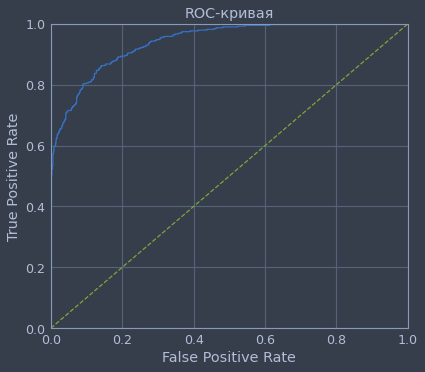

In [75]:
fpr, tpr, thresholds = roc_curve(target_test, predict_one) 

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Матрица ошибок:

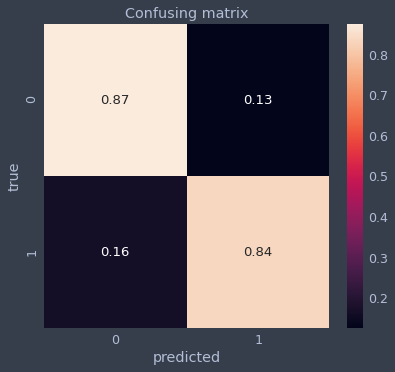

In [101]:
cm = confusion_matrix(target_test, predict)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel='predicted', ylabel='true')
ax.set_title("Confusing matrix");

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

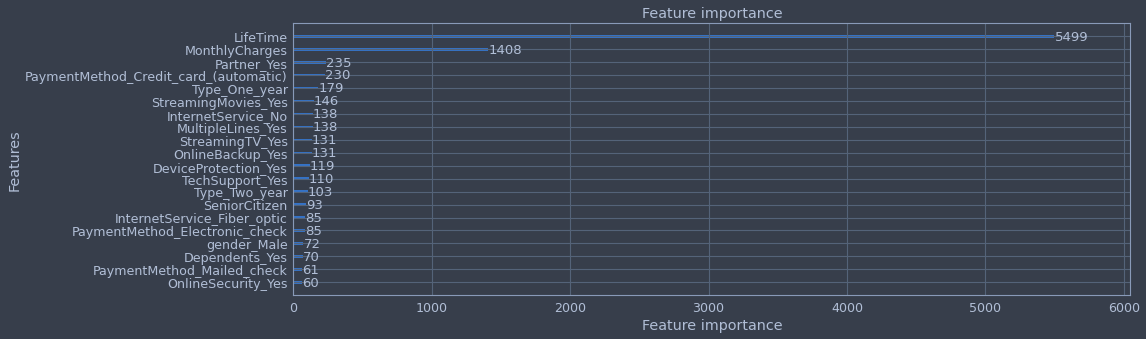

In [108]:
lgb.plot_importance(model, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', figsize=(15,5))

предсказуемо, наибольшую важность делают время жизни и размер месячного платежа. Так же автоматическая оплата карточкой интуитивно подсказывала привязанность. Интересно что наличие партнера на третьем месте.

**ИТОГОВЫЙ ВЫВОД:**

По итогу проекта мы продедали следующую работу:  
1. Загрузили и оценили данные.  
2. Преобразовали поля к нужным типам.  
3. Избавились от лишних признаов, в том числе после оценки мультиколинеарности.  
4. Закодировали признаки методом OHE
5. Обучили и оценили 5 моделей, подобрали параметры для максимизации качества моделей.
6. Протестировали модель с лучшими результатами.

Наилучшие результаты показали модели градиентного бустинга. Среди них особенно выделяется модель LGBM, так как показала хорошее качество с дефолтными параметрами и обеспечила 5% прирост за счёт тюнинга. Так же можно отметить высокую скорость работы модели. catboost оказалась в 3 раза медленнее, хотя среди преимуществ разработчики выделяют как раз производительность в сравнении с тем же LGB. Так же модель дала минимальный прирост от тюнинга, фактически ни один параметр кроме n_estimators не оказал никакого значения на качество модели. Немного улучшить качество удалось за счёт кодирования методом Ordinal encoder.  
На тестовой выборке получили результат даже немного выше кросс валидации, ориентируясь на метрику Accuracy, можно сказать что мы научились предсказывать отток с вероятностью 86%.
